# Dota 2 Match Outcome Prediction with Deep Neural Networks
### Introduction

In this program, we’ll build a Deep Neural Network (DNN) to predict the outcome of Dota 2 matches based on tabular data. Dota 2 is a popular multiplayer online battle arena (MOBA) game, and our goal is to create a model that can predict whether a team will win or lose a match.
Libraries and Dependencies

First, let’s import the necessary libraries and load the training and test data from CSV files. Make sure the files (dota2Train.csv and dota2Test.csv) are in the same folder as this notebook.

In [2]:
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt #visualization
from keras.models import Sequential #simple feedforward network
from keras.layers import Dense, Dropout #fully connected layers, reguralization layer
from keras.optimizers import Adam #weight update optimizer
from keras.callbacks import EarlyStopping 
from sklearn.preprocessing import MinMaxScaler #data normalization
from sklearn.model_selection import train_test_split #valuation set creation
from sklearn.linear_model import LogisticRegression #benchmark model
from sklearn.ensemble import RandomForestClassifier #benchmark model
from sklearn.metrics import accuracy_score, classification_report #evaluation
from imblearn.over_sampling import SMOTE
import warnings #ignore warnings
warnings.filterwarnings("ignore")

# Import Data, the 2 .csv files should be in the same folder as this notebook
#train_df = pd.read_csv('/kaggle/input/dota2-dataset/dota2Train.csv', header = None)
train_df = pd.read_csv('dota2Train.csv', header = None) #Change to this at the end
#test_df = pd.read_csv('/kaggle/input/dota2-dataset/dota2Test.csv', header = None)
test_df = pd.read_csv('dota2Test.csv', header = None) #Change to this at the end

# Valuation Set Creation
train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 42)

# Column Renaming
train_df.columns = val_df.columns = test_df.columns = ['target'] + [f'x{i:}' for i in range(1,train_df.shape[1])]

# Display Data
train_df.head()

,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116
75081,1,152,2,2,0,0,0,0,0,1,...,0,-1,0,0,0,0,0,0,0,0
58386,1,153,2,2,-1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
14808,1,154,2,2,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
19997,-1,155,2,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
37531,1,154,2,2,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0


### Feature Sets

We split the input features and labels for training, validation, and test sets:

In [3]:
# Split Input and Label Feature Sets for Train,Validation, Test
train_features = train_df.drop(['target'], axis = 1)
train_labels = train_df['target']

val_features = val_df.drop(['target'], axis = 1)
val_labels = val_df['target']

test_features = test_df.drop(['target'], axis = 1)
test_labels = test_df['target']


scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.fit_transform(test_features)
val_features = scaler.fit_transform(val_features)


# In order to compute the binary cross entropy loss, 
# it is best that we se the labels 0 and 1 instead of -1 and 1
train_labels = (train_labels==1).astype(int)
val_labels = (val_labels==1).astype(int)
test_labels = (test_labels==1).astype(int)

smote = SMOTE(random_state=42)
train_features, train_labels = smote.fit_resample(train_features, train_labels)

# Check sizes to ensure datasets are correct
print(f"Train input shape: {train_features.shape}")
print(f"Validation input shape: {val_features.shape}")
print(f"Test input shape: {test_features.shape}")

print(f"Train labels shape: {train_labels.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")


Train input shape: (78050, 116)
Validation input shape: (18530, 116)
Test input shape: (10294, 116)
Train labels shape: (78050,)
Validation labels shape: (18530,)
Test labels shape: (10294,)


## Building the Deep Neural Network (DNN)

### 1. Model Architecture:
- We create a sequential model using Keras. This means that the layers are stacked sequentially.
- The first layer has 256 neurons with a ReLU activation function.
- We add dropout layers after each hidden layer to prevent overfitting. The dropout rate is set to 20%.
- The second hidden layer has 128 neurons, followed by another dropout layer.
- The third hidden layer has 64 neurons and a dropout layer.
- Finally, the output layer has 1 neuron with a sigmoid activation function (since we’re doing binary classification).


In [4]:
# Lets create a Deep Neural Network, with 3 hidden layers 
model = Sequential()
model.add(Dense(256, input_shape = (train_features.shape[-1],), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

### 2. Training and optimizing the model
- We choose the Adam optimizer with a learning rate of 0.0001.
- The loss function is binary cross-entropy (since it’s a binary classification problem).
- We also track accuracy as a metric during training.

In [5]:
# Choose and Tweak the optimizer's hyperparameters
adam = Adam(learning_rate = 0.0001)

# We have to build the model, specifying the update method and the metrics
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the training data to the model
history = model.fit(train_features,
          train_labels,
          validation_data=(val_features, val_labels),
          verbose = 1,
          epochs = 50,
          batch_size= 128,
          callbacks=[early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        29,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,169 (278.00 KB)

 Trainable params: 71,169 (278.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5162 - loss: 0.6963 - val_accuracy: 0.5486 - val_loss: 0.6865
Epoch 2/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5498 - loss: 0.6855 - val_accuracy: 0.5786 - val_loss: 0.6763
Epoch 3/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5680 - loss: 0.6797 - val_accuracy: 0.5860 - val_loss: 0.6710
Epoch 4/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5768 - loss: 0.6757 - val_accuracy: 0.5792 - val_loss: 0.6731
Epoch 5/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5844 - loss: 0.6729 - val_accuracy: 0.5862 - val_loss: 0.6677
Epoch 6/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5827 - loss: 0.6727 - val_accuracy: 0.5915 - val_loss: 0.6666
Epoch 7/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5894 - loss: 0.6707 - val_accuracy: 0.5926 - val_loss: 0.6662
Epoch 8/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5954 - loss: 0.6686 - val_accuracy: 0.

### 3. Evaluation:
- We evaluate the model on the validation and test sets.
- The validation loss and accuracy are printed.

In [6]:
val_loss, val_accuracy = model.evaluate(val_features, val_labels, verbose=0)
test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=0)
print(f"Validation loss: {val_loss:3f}, Validation accuracy: {val_accuracy*100:3f}%")
print(f"Test loss: {test_loss:3f}, Test accuracy: {test_accuracy*100:3f}%")

Validation loss: 0.664233, Validation accuracy: 59.611440%
Test loss: 0.665255, Test accuracy: 59.112102%


Having closely matched validation and testing accuracies is a positive sign. It suggests that our model is robust and performs consistently on both seen and unseen data

### 4. Plotting Accuracy:
- We plot the training and validation accuracy over the epochs.


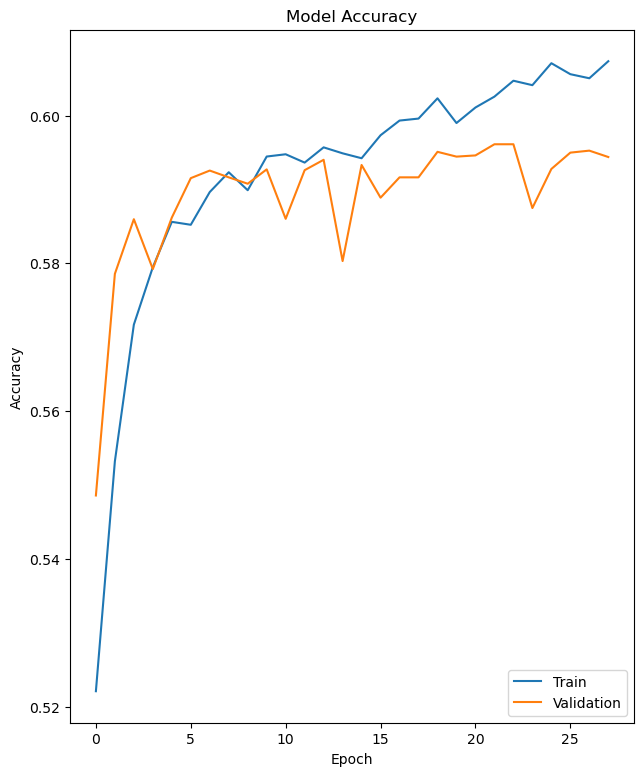

In [7]:
plt.figure(figsize = (16,9))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc="lower right")
plt.show()

### 5. Benchmark Models:
- We create two benchmark models: a logistic regression model (benchmark_1) and a random forest classifier (benchmark_2).
- We fit these models to the training data and evaluate their accuracy on the validation and test sets.


In [8]:
benchmark_1 = LogisticRegression()
benchmark_1.fit(train_features, train_labels)
benchmark_2 = RandomForestClassifier()
benchmark_2.fit(train_features, train_labels)

models = [benchmark_1,benchmark_2]

for m in models:
    val_prediction = m.predict(val_features)
    test_prediction = m.predict(test_features)
    print(f"{str(m)} Validation Accuracy: {accuracy_score(val_labels, val_prediction)*100:2f}%")
    print(f"{str(m)} Test Accuracy: {accuracy_score(test_labels, test_prediction)*100:2f}%")
print(f"Our Model's Validation accuracy: {val_accuracy*100:3f}%")
print(f"Our Model's Test accuracy: {test_accuracy*100:3f}%")

LogisticRegression() Validation Accuracy: 59.633028%
LogisticRegression() Test Accuracy: 59.617253%
RandomForestClassifier() Validation Accuracy: 57.641662%
RandomForestClassifier() Test Accuracy: 57.956091%
Our Model's Validation accuracy: 59.611440%
Our Model's Test accuracy: 59.112102%


### Summary
While our model lacks preprocessing or advanced techniques, it provides an improvement over some of the benchmark models. Keep in mind that further enhancements (such as feature engineering, hyperparameter tuning, or more complex architectures) could potentially yield even better results.